<a href="https://colab.research.google.com/github/karthikcar/Action-Recognition-for-videos/blob/main/predict_and_cluster_for_time_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Aug 24 08:55:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   42C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 56.9 gigabytes of available RAM

You are using a high-RAM runtime!


In [1]:
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import cv2
import PIL
import os
import shutil
import random

In [ ]:
# #creating a folder to store each video
# !mkdir videos
# !mkdir videos/train
# !mkdir videos/val
# !mkdir videos/test

In [ ]:
!git remote add origin https://github.com/Optifye/time_segmentation_using_predict-and-cluster.git
!git branch -M main
!git push -u origin main

### Reading input

In [ ]:
video_path = "/content/drive/MyDrive/CCTV/camera no 14 (1 Hours)/D14_S20240821140000_E20240821151238.mp4"

In [ ]:
# Get video properties
cap = cv2.VideoCapture(video_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(f"Width: {width}, Height: {height}")
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Frames per second: {fps}")
print(f"Total frames: {total_frames}")

Width: 1920, Height: 1080
Frames per second: 25
Total frames: 108900


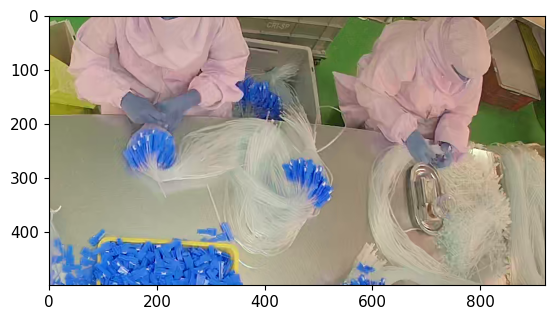

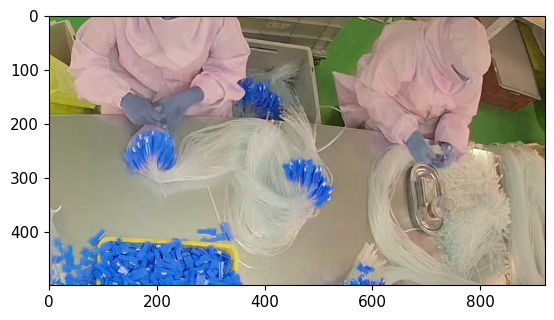

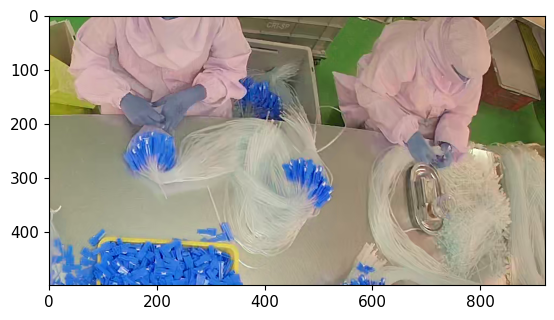

In [ ]:
%matplotlib inline
cap = cv2.VideoCapture(video_path)
i= 0
while cap.isOpened() and i<3:
  ret, frame = cap.read()
  if not ret:
    print("End of video.")
    break
        # input_video.write(frame)
  # print(frame.shape)
  plt.imshow(frame[:500,1000:,:])
  plt.show()
  if cv2.waitKey(2) & 0xFF == ord('q'):
      break
  i+=1
cap.release()
    # input_video.release()
cv2.destroyAllWindows()

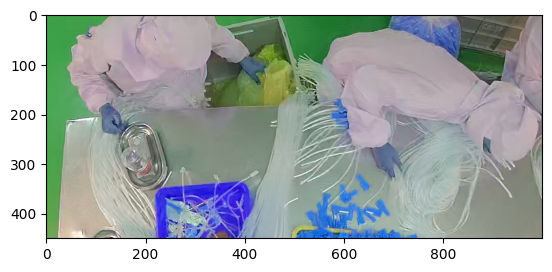

In [ ]:
%matplotlib inline
cap = cv2.VideoCapture(video_path)
i= 0
while cap.isOpened() and i<3:
  ret, frame = cap.read()
  if not ret:
    print("End of video.")
    break
        # input_video.write(frame)
  # print(frame.shape)
  plt.imshow(frame[:450,600:1600,:])
  plt.show()
  if cv2.waitKey(2) & 0xFF == ord('q'):
      break
  break
  i+=1
cap.release()
    # input_video.release()
cv2.destroyAllWindows()

In [ ]:
height, width,_ = frame[:450,600:1600,:].shape
width, height

(1000, 450)

In [ ]:
#here we are saving each video into train -test -val directory
# Set the output directories for train, val, and test

train_dir = "/content/videos/train"
val_dir = "/content/videos/val"
test_dir = "/content/videos/test"

# Open the video file
cap = cv2.VideoCapture(video_path)

# Define how many frames per segment
frames_per_segment = 10

# Counters for file names
train_counter = 0
val_counter = 0
test_counter = 0

# Frame indices
frame_idx = 0
segment_idx = 0

# Function to save video segment
def save_video_segment(segment_frames, output_dir, counter):
    segment_file = os.path.join(output_dir, f'segment_{counter:04d}.mp4')
    height, width, _ = segment_frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(segment_file, fourcc, fps, (width, height))

    for frame in segment_frames:
        out.write(frame)

    out.release()

# Main loop to process video frames
segment_frames = []
while True:
    ret, frame = cap.read()

    if not ret:
        break



    if frame_idx%2 == 0:
      segment_frames.append(frame[:500,100:1250,:])
      if len(segment_frames) == frames_per_segment:
          # Randomly assign the segment to train, val, or test
          assignment = random.choices(['train', 'val', 'test'], weights=(0.9, 0.05, 0.05))[0]

          if assignment == 'train':
              save_video_segment(segment_frames, train_dir, train_counter)
              train_counter += 1
          elif assignment == 'val':
              save_video_segment(segment_frames, val_dir, val_counter)
              val_counter += 1
          else:
              save_video_segment(segment_frames, test_dir, test_counter)
              test_counter += 1

          # Reset for next segment
          segment_frames = []
          segment_idx += 1

      # Stop if end of video is reached
    if frame_idx//2 >= total_frames:
          break
    frame_idx += 1
# Release the video capture object
cap.release()

print(f'Finished processing {segment_idx} segments.')
print(f'Train segments: {train_counter}, Validation segments: {val_counter}, Test segments: {test_counter}')


Finished processing 2184 segments.
Train segments: 1983, Validation segments: 96, Test segments: 105


### HR Net

In [3]:
!git clone https://github.com/stefanopini/simple-HRNet.git

Cloning into 'simple-HRNet'...
remote: Enumerating objects: 420, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 420 (delta 85), reused 73 (delta 73), pack-reused 319 (from 1)
Receiving objects: 100% (420/420), 78.05 MiB | 25.42 MiB/s, done.
Resolving deltas: 100% (217/217), done.


In [4]:
%cd simple-HRNet
!pwd

/content/simple-HRNet
/content/simple-HRNet


In [5]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [6]:
!git submodule update --init --recursive

Submodule 'models/detectors/yolo' (https://github.com/eriklindernoren/PyTorch-YOLOv3) registered for path 'models_/detectors/yolo'
Cloning into '/content/simple-HRNet/models_/detectors/yolo'...
Submodule path 'models_/detectors/yolo': checked out '47b7c912877ca69db35b8af3a38d6522681b3bb3'


In [7]:
%cd /content/simple-HRNet/models_/detectors/yolo
!pip install -q -r requirements.txt

%cd /content/simple-HRNet


/content/simple-HRNet/models_/detectors/yolo
/content/simple-HRNet


In [8]:
# %cd /content/simple-HRNet/models_/detectors/yolo/weights
# !sh download_weights.sh

%cd /content/simple-HRNet

/content/simple-HRNet


In [9]:
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 5.1.0
    Uninstalling gdown-5.1.0:
      Successfully uninstalled gdown-5.1.0


In [10]:

# download weights

# create weights folder
%cd /content/simple-HRNet
!mkdir weights
%cd /content/simple-HRNet/weights

# # download weights pose_hrnet_w48_384x288.pth
# !gdown "1UoJhTtjHNByZSm96W3yFTfU5upJnsKiS&confirm=t"

# download weights pose_hrnet_w32_256x192.pth (keypoints are in coco format)
!gdown 1zYC7go9EV0XaSlSBjMaiyE_4TcHc_S38

/content/simple-HRNet
/content/simple-HRNet/weights
Downloading...
From (original): https://drive.google.com/uc?id=1zYC7go9EV0XaSlSBjMaiyE_4TcHc_S38
From (redirected): https://drive.google.com/uc?id=1zYC7go9EV0XaSlSBjMaiyE_4TcHc_S38&confirm=t&uuid=27d6abb0-8946-43b9-b5e3-a612f55bdf82
To: /content/simple-HRNet/weights/pose_hrnet_w32_256x192.pth
100% 115M/115M [00:01<00:00, 107MB/s]


In [11]:
!pip install ultralytics # for yolo model
!pip install boxmot # for byte track
!pip install supervision # for byte track

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.4/869.4 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 12.6 MB/s eta 0:00:00
   ━━━━━

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 5.3 MB/s eta 0:00:00


In [2]:
%cd /content/simple-HRNet

/content/simple-HRNet


In [3]:

import cv2
import requests
import matplotlib.pyplot as plt
import torch
from skimage import io
from PIL import Image
from SimpleHRNet import SimpleHRNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


In [4]:
# # multiperson w/ YOLOv5 (medium), COCO weights w32_256x192 (small model)
hr_net = SimpleHRNet(32, 17, "/content/simple-HRNet/weights/pose_hrnet_w32_256x192.pth",resolution=(256,192), yolo_version='v10', yolo_model_def='yolov10m', device=device)

device: 'cuda' - 1 GPU(s) will be used
v10


100%|██████████| 32.1M/32.1M [00:00<00:00, 127MB/s]


### Loading Keypoints

In [ ]:
# from scipy.spatial.distance import cdist

In [ ]:
%cd /content/simple-HRNet

/content/simple-HRNet


In [5]:
import numpy as np
import cv2
import requests
import matplotlib.pyplot as plt
import torch
from skimage import io
import os
from PIL import Image
from SimpleHRNet import SimpleHRNet
from misc.visualization import joints_dict

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
%cd /content/

/content


In [7]:
def proj(v1, v2):
    # Projection of v2 onto v1
    if np.dot(v2, v2) == 0:
      return (np.dot(v2, v1) / 1) * v2
    return (np.dot(v2, v1) / np.dot(v2, v2)) * v2

def compute_rotation_matrix_inverse(v1, v2):
    # Normalize v1
    # if np.linalg.norm(v1):
    #     return np.eye(3)
    v1_norm = v1
    if np.linalg.norm(v1)!=0:
        v1_norm = v1 / np.linalg.norm(v1)

    # Compute the orthogonal vector v_hat_2
    v_hat_2 = v2 - proj(v1, v2)

    if np.linalg.norm(v_hat_2) !=0:
      v_hat_2 /= np.linalg.norm(v_hat_2)

    # Compute the third orthogonal vector as cross product of v1_norm and v_hat_2
    v3 = np.cross(v1_norm, v_hat_2)

    # Construct the rotation matrix R
    R = np.column_stack((v1_norm, v_hat_2, v3))

    # Inverse of R is the transpose of R since it's a rotation matrix
    R_inverse = np.transpose(R)

    return R_inverse

In [8]:
def view_invariant_transform(joints):
  v1_ = (joints[:,5,:] + joints[:,6,:])//2
  v1__ = (joints[:,11,:]+joints[:,12,:])//2
  v1 = v1_ - v1__
  v2 = joints[:,6,:]-joints[:,5,:]
  Rotation = np.array([compute_rotation_matrix_inverse(v1[i],v2[i]) for i in range(v1.shape[0])])
  translate = np.mean(joints,axis=1,keepdims=True)
  new_joints= np.matmul(joints-translate,Rotation)
  return new_joints

In [11]:

def key_points_extraction_visualize(vid_path,no_persons):
  cv2_video = cv2.VideoCapture(vid_path)
  key_points = [] # storing keypoints of each frame
  trackings = [] # stroing tracking ids
  fps = 0
  while cv2_video.isOpened() and fps<54451:
      success, frame = cv2_video.read()
      if not success:
          break
      #[:500,1000:,:]
      if fps%2 ==0 :
        frame = frame[:500,1000:,:]

        joints,track_ids,color_map = hr_net.predict(frame) #detecting keypoints
        fig = plt.figure(figsize=(60/2.54, 30/2.54))
        ax = fig.add_subplot(121)
        ax.imshow(frame)
        ax = fig.add_subplot(122)
        plot_boxes(frame, track_ids[:5], color_map)
        ax.imshow(frame)
        plot_joints(ax, joints[:5])
        plt.show()
        if fps >6:
          break
        # print(joints.shape)
        key_points.append(joints)
        trackings.append(track_ids[:,-1])
        print(f"current frame {fps}")
      fps+=1
  cv2_video.release()
  cv2.destroyAllWindows()
  print("Number of frames per second", fps)
  return key_points, trackings



In [17]:

def key_points_extraction(vid_path,no_persons):
  cv2_video = cv2.VideoCapture(vid_path)
  key_points = [] # storing keypoints of each frame
  trackings = [] # stroing tracking ids
  fps = 0
  while cv2_video.isOpened() and fps<54451:
      success, frame = cv2_video.read()
      if not success:
          break
      #[:500,1000:,:]
      if fps%2 ==0 :
        frame = frame[:500,1000:,:]

        joints,track_ids,color_map = hr_net.predict(frame) #detecting keypoints
        # fig = plt.figure(figsize=(60/2.54, 30/2.54))
        # ax = fig.add_subplot(121)
        # ax.imshow(frame)
        # ax = fig.add_subplot(122)
        # plot_boxes(frame, track_ids[:5], color_map)
        # ax.imshow(frame)
        # plot_joints(ax, joints[:5])
        # plt.show()
        # if fps >6:
        #   break
        # print(joints.shape)
        key_points.append(joints)
        trackings.append(track_ids[:,-1])
        print(f"current frame {fps}")
      fps+=1
  cv2_video.release()
  cv2.destroyAllWindows()
  print("Number of frames per second", fps)
  return key_points, trackings



In [29]:
def key_point_preprocess(key_points,trackings,fps,no_persons):
  key_points_ = [key_points[i][trackings[i]>0] for i in range(len(key_points))] #excluding keypoints that are not tracked
  key_points_store  = np.zeros((no_persons,fps,13,3)) # storing tracked keypoints in an array
  # print(key_points_[0].shape)
  for i in range(len(key_points_)):
    print(len(key_points_[i]))
    if key_points_[i].shape[1]!=0:
      if len(key_points_[i])<no_persons+1:
        key_points_store[:len(key_points_[i]),i,:,:] = key_points_[i][:,:13,:]
      else:
          key_points_store[:,i,:,:] = key_points_[i][:no_persons,:13,:]
  # key_points_store = key_points_store.reshape(-1,fps,17,3)
  print(key_points_store.shape,key_points_store.shape[0])
  # if key_points_store.shape[1]!=0:
  key_points_view_invariant = np.array([view_invariant_transform(key_points_store[i])
                                          for i in range(key_points_store.shape[0])])

  key_points_view_invariant = key_points_view_invariant/np.array([150,150,1]) # normalizing x,y to -1 to 1
  return key_points_view_invariant

In [14]:
def plot_boxes(frame, track_ids, color_map):
    for i, track_id in enumerate(track_ids):
        if track_id[-1] in color_map:
          color = color_map[track_id[-1]]
            # Draw bounding box
          cv2.rectangle(frame, (int(track_id[0]), int(track_id[1])), (int(track_id[2]), int(track_id[3])), color, 3)

                  # Add label
          label = f"Worker #{int(track_id[-1])}"
          cv2.putText(frame, label, (int(track_id[0]), int(track_id[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

def plot_joints(ax, output):
    bones = joints_dict()["coco"]["skeleton"] # if the weights of hr net is coco
    # bones = joints_dict()["mpii"]["skeleton"] # if the weights of hr net is mpii

    for bone in bones:
        if max(bone):
          xS = [output[:,bone[0],1], output[:,bone[1],1]]
          yS = [output[:,bone[0],0], output[:,bone[1],0]]
          ax.plot(xS, yS, linewidth=3, c=(0,0.3,0.7))

    ax.scatter(output[:,:,1],output[:,:,0], s=20, c='r')

In [15]:
video_path = "/content/drive/MyDrive/CCTV/camera no 14 (1 Hours)/D14_S20240821140000_E20240821151238.mp4"


0: 352x640 3 persons, 1 carrot, 2 chairs, 157.1ms
Speed: 13.6ms preprocess, 157.1ms inference, 47.8ms postprocess per image at shape (1, 3, 352, 640)


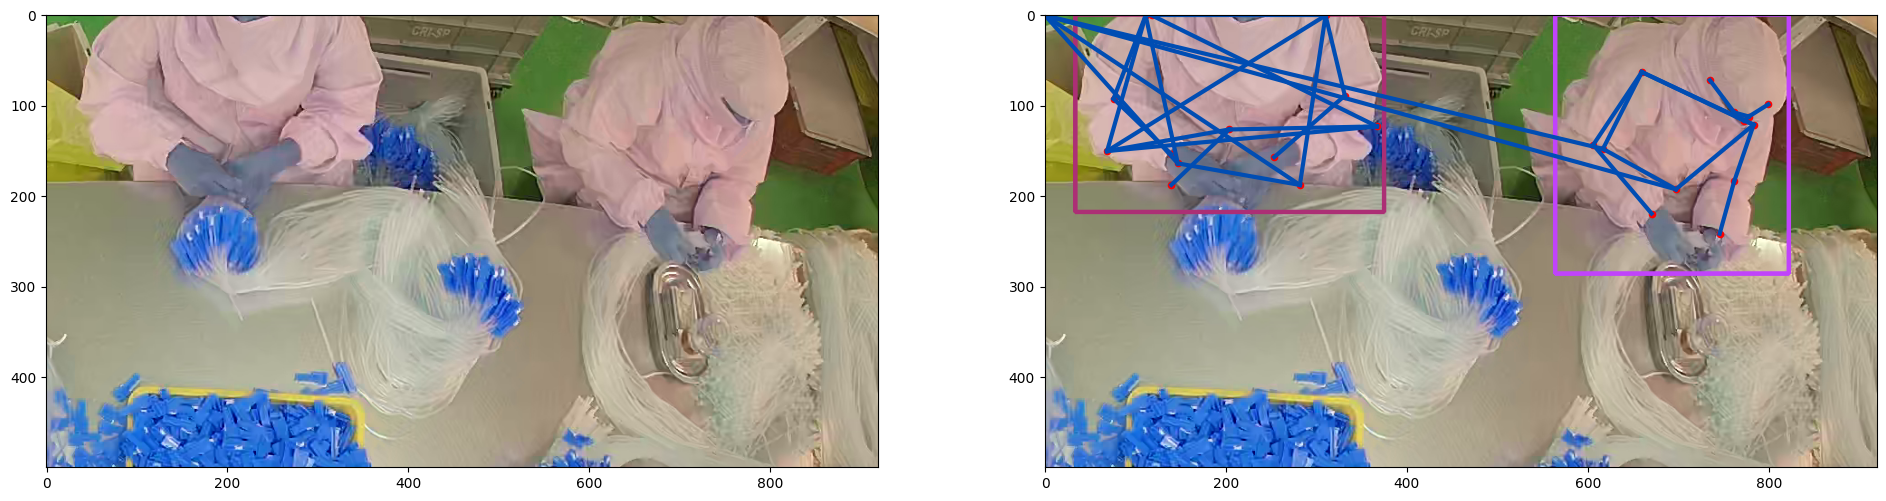

current frame 0

0: 352x640 3 persons, 1 carrot, 2 chairs, 21.8ms
Speed: 2.4ms preprocess, 21.8ms inference, 0.6ms postprocess per image at shape (1, 3, 352, 640)


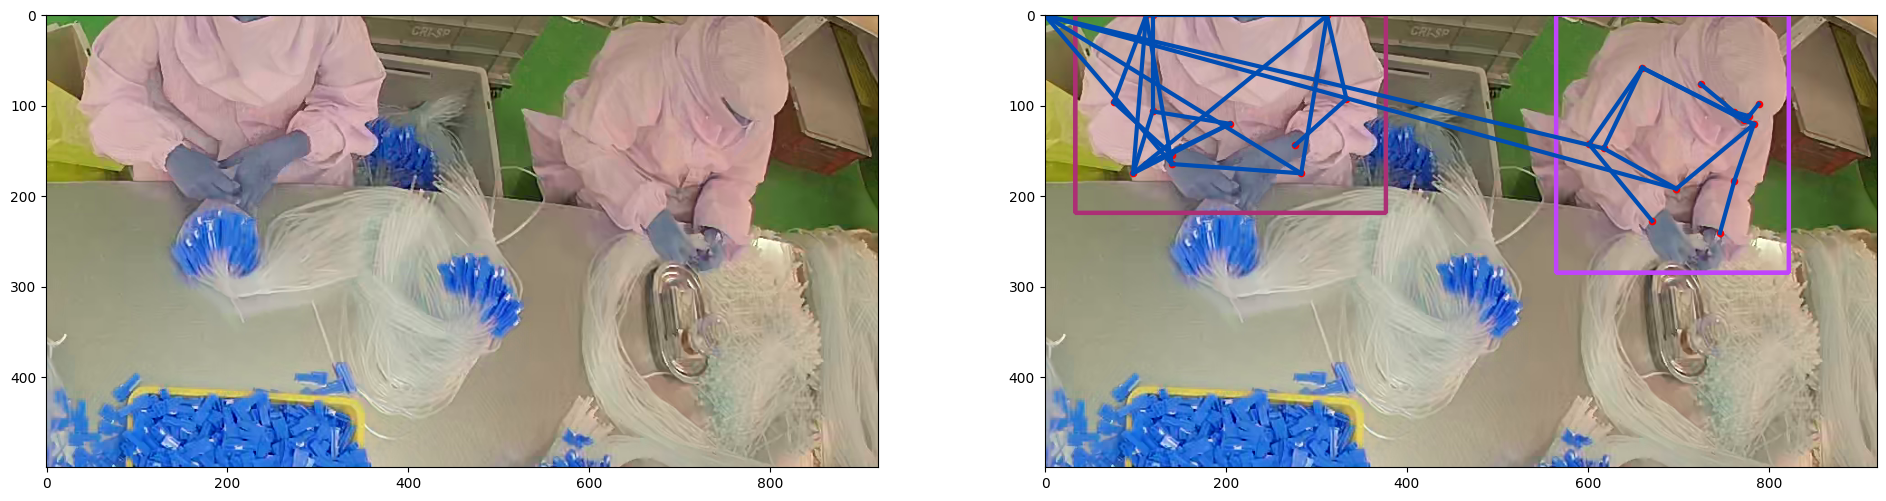

current frame 2

0: 352x640 3 persons, 1 fork, 1 carrot, 2 chairs, 14.9ms
Speed: 1.9ms preprocess, 14.9ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)


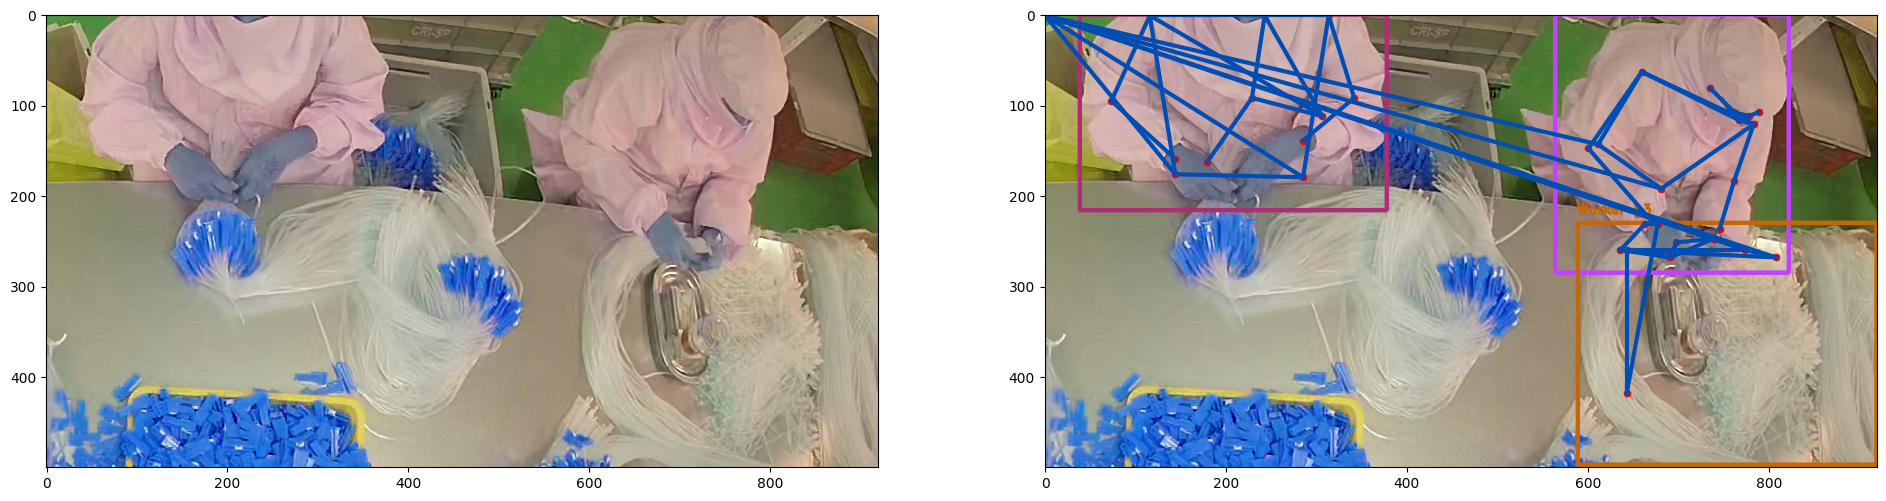

current frame 4

0: 352x640 3 persons, 1 fork, 1 carrot, 2 chairs, 15.2ms
Speed: 1.9ms preprocess, 15.2ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)


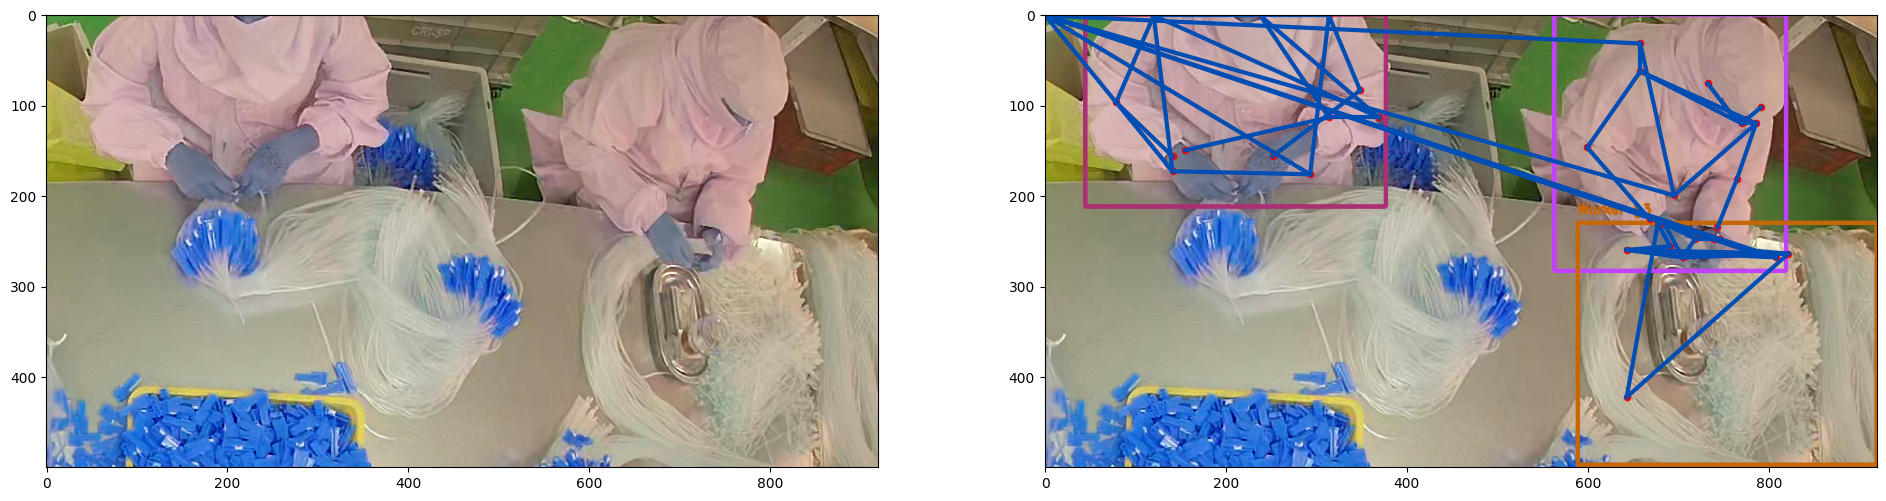

current frame 6

0: 352x640 3 persons, 1 fork, 1 carrot, 2 chairs, 15.2ms
Speed: 1.9ms preprocess, 15.2ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)


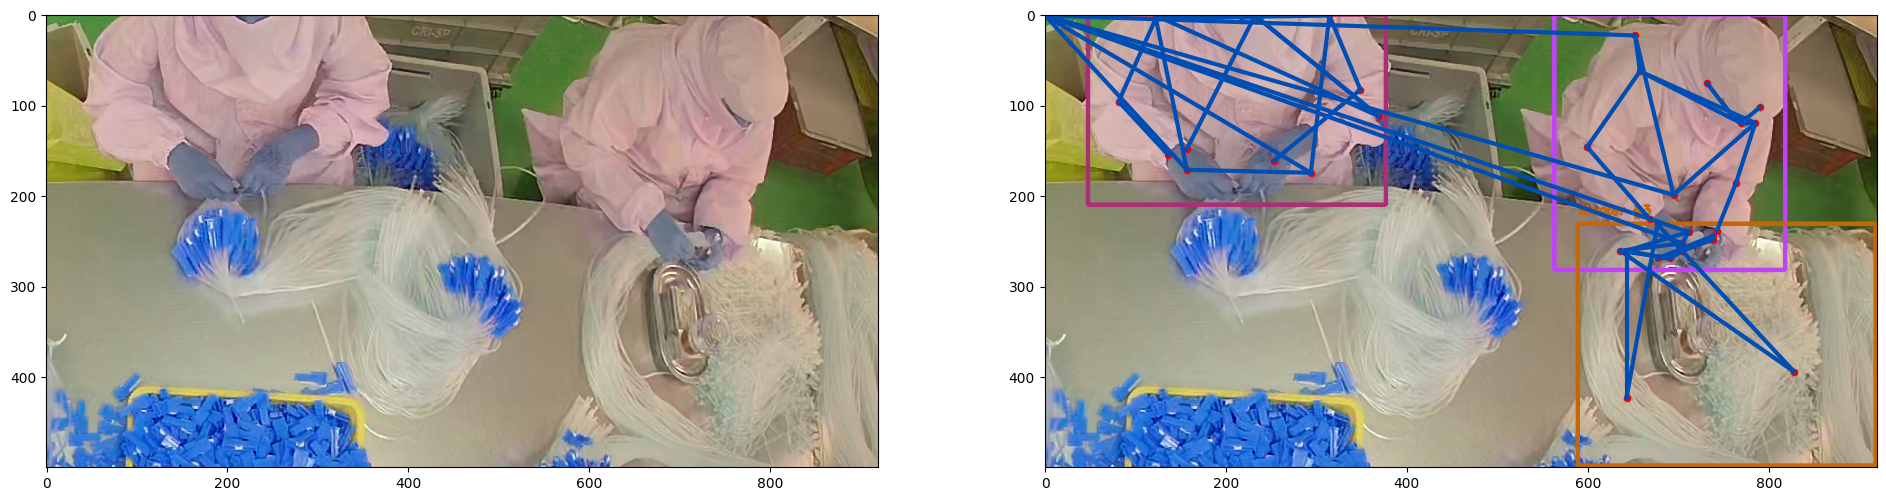

Number of frames per second 8


In [16]:
_,_  = key_points_extraction_visualize(video_path, 2)


In [18]:
key_points_,trackings_  = key_points_extraction(video_path, 2)


Streaming output truncated to the last 5000 lines.
0: 352x640 2 persons, 4 carrots, 15.5ms
Speed: 2.0ms preprocess, 15.5ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)
current frame 51952

0: 352x640 3 persons, 4 carrots, 15.6ms
Speed: 2.0ms preprocess, 15.6ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)
current frame 51954

0: 352x640 2 persons, 4 carrots, 17.2ms
Speed: 2.8ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)
current frame 51956

0: 352x640 3 persons, 4 carrots, 16.2ms
Speed: 2.1ms preprocess, 16.2ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)
current frame 51958

0: 352x640 2 persons, 4 carrots, 16.2ms
Speed: 1.9ms preprocess, 16.2ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)
current frame 51960

0: 352x640 2 persons, 4 carrots, 17.3ms
Speed: 1.9ms preprocess, 17.3ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)
current frame 51962

0

In [21]:
trackings_[-1],trackings_[-2]

(array([        607,         637]), array([        607,         637]))

In [30]:
key_points_data = key_point_preprocess(key_points_,trackings_,len(key_points_),2)

Streaming output truncated to the last 5000 lines.
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
4
4
4
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
0
0
0
0
0
0
0
0
0
0
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2

In [ ]:
# key_points_data  = key_points_extraction('/content/videos/test/segment_0000.mp4',2)

In [31]:
key_points_data.shape

(2, 27226, 13, 3)

In [ ]:
# def proj(v1, v2):
#     # Projection of v2 onto v1
#     if np.dot(v2, v2) == 0:
#       return (np.dot(v2, v1) / 1) * v2
#     return (np.dot(v2, v1) / np.dot(v2, v2)) * v2

# def compute_rotation_matrix_inverse(v1, v2):
#     # Normalize v1
#     # if np.linalg.norm(v1):
#     #     return np.eye(3)
#     v1_norm = v1
#     if np.linalg.norm(v1)!=0:
#         v1_norm = v1 / np.linalg.norm(v1)

#     # Compute the orthogonal vector v_hat_2
#     v_hat_2 = v2 - proj(v1, v2)

#     if np.linalg.norm(v_hat_2) !=0:
#       v_hat_2 /= np.linalg.norm(v_hat_2)

#     # Compute the third orthogonal vector as cross product of v1_norm and v_hat_2
#     v3 = np.cross(v1_norm, v_hat_2)

#     # Construct the rotation matrix R
#     R = np.column_stack((v1_norm, v_hat_2, v3))

#     # Inverse of R is the transpose of R since it's a rotation matrix
#     R_inverse = np.transpose(R)

#     return R_inverse

In [ ]:
# def rot_tran(joints):
#   v1_ = (joints[:,5,:] + joints[:,6,:])//2
#   v1__ = (joints[:,11,:]+joints[:,12,:])//2
#   v1 = v1_ - v1__
#   v2 = joints[:,6,:]-joints[:,5,:]
#   Rotation = np.array([compute_rotation_matrix_inverse(v1[i],v2[i]) for i in range(v1.shape[0])])
#   translate = np.mean(joints,axis=1,keepdims=True)
#   new_joints= np.matmul(joints-translate,Rotation)
#   return new_joints

In [ ]:
# [1,1,3],[1,2,3],[1,3,4],[1,4,5]
# [1,2,3],[2,3,4],[5,6,7],[0,0,0]

In [ ]:
# def rot_tran(joints):
#   dif = joints[:,0,:]-(joints[:,11,:]+joints[:,12,:])/2
#   # thetas = np.arctan2(dif[:,0],1)
#   if np.linalg.norm(dif):
#     cos_thetas = np.matmul(dif,np.array([[1],[0],[0]]))/np.linalg.norm(dif)
#   else:
#     cos_thetas = np.matmul(dif,np.array([[1],[0],[0]]))
#   cos_thetas = cos_thetas.squeeze()
#   Rotation = np.array([np.array([[cos,-(1-cos**2)**0.5,0],[(1-cos**2)**0.5,cos,0],[0,0,1]]) for cos in cos_thetas])
#   # Rotation = np.array([rodrigues_rotation_matrix(dif[i,:],np.array([0,0,1])) for i in range(dif[:,0].shape[0])])
#   translate = np.mean(joints,axis=1,keepdims=True)
#   new_joints= np.matmul(joints-translate,Rotation)
#   return new_joints

In [ ]:
# a = [np.random.randn(5,17,3),np.random.randn(4,17,3),
#      np.random.randn(3,17,3),np.random.randn(2,17,3),np.random.randn(17,3)]
# track_keypoints_across_frames(a).shape

In [ ]:
# np.argmin([1,2,3])

In [ ]:
# def track_keypoints_across_frames(frames_keypoints, num_persons=4):
#     num_frames = len(frames_keypoints)
#     num_keypoints = 17 * 3  # 17 keypoints, 3 coordinates each

#     # Initialize the tracked keypoints array with zeros
#     tracked_keypoints = np.zeros((num_persons, num_frames, num_keypoints))

#     # Handle the first frame
#     initial_frame_keypoints = frames_keypoints[0].reshape(-1, num_keypoints)
#     num_detected_persons = min(initial_frame_keypoints.shape[0], num_persons)
#     tracked_keypoints[:num_detected_persons, 0, :] = initial_frame_keypoints[:num_detected_persons]

#     # Iterate over the frames to track keypoints
#     for t in range(1, num_frames):
#         current_keypoints = frames_keypoints[t].reshape(-1, num_keypoints)
#         previous_keypoints = tracked_keypoints[:, t-1, :]

#         if current_keypoints.shape[0] == 1:
#             tracked_keypoints[0, t, :] = current_keypoints[0]
#         else:
#             num_detected_persons = min(current_keypoints.shape[0], num_persons)
#             distances = cdist(current_keypoints[:num_detected_persons], previous_keypoints, metric='euclidean')

#             for i in range(num_detected_persons):
#                 min_dist_idx = np.argmin(distances[i])
#                 tracked_keypoints[min_dist_idx, t, :] = current_keypoints[i]

#     return tracked_keypoints


In [ ]:
# def track_keypoints_across_frames(frames_keypoints, num_persons=4):
#     num_frames = len(frames_keypoints)
#     # num_keypoints = frames_keypoints[0].shape[1]  # Assuming each detected person has the same number of keypoints

#     # Initialize the tracked keypoints array with NaNs (or zeros)
#     tracked_keypoints = np.full((4, num_frames, 51), 0)

#     # Assign the first frame's keypoints to the tracked array
#     # print(len(frames_keypoints[0].shape))
#     # print(tracked_keypoints[0,0,:,:].shape)

#     # if len(frames_keypoints[0].shape) == 2:
#     #   # tracked_keypoints[:frames_keypoints[0].shape[0], 0, :, :] = frames_keypoints[0
#     #   tracked_keypoints[0, 0, :, :] = frames_keypoints[0]
#     # # elif frames_keypoints[0].shape[0] > 4:
#     # #   tracked_keypoints[:4 0, :, :] = frames_keypoints[0]
#     # else:
#       # tracked_keypoints[:frames_keypoints[0].shape[0], 0, :, :] = frames_keypoints[0]
#     # Iterate over the frames to track keypoints
#     for t in range(0, num_frames):
#           # print(frames_keypoints[t].shape)
#           # print(frames_keypoints[t].shape)
#           if t ==0:
#             if len(frames_keypoints[0].shape) == 2:
#               tracked_keypoints[0, 0, :] = frames_keypoints[0].reshape(17*3)

#             else:
#               current_keypoints = frames_keypoints[0].reshape(-1,17*3)
#               if current_keypoints.shape[0] >=4:
#                 current_keypoints = current_keypoints[:4]
#               tracked_keypoints[:frames_keypoints[0].shape[0], 0, :] = current_keypoints

#           elif len(frames_keypoints[t].shape)==2 and t != 0:
#             # print(len(frames_keypoints[t].shape))
#             tracked_keypoints[0, t, :] = frames_keypoints[t].reshape(-1,17*3)

#           else:

#             current_keypoints = frames_keypoints[t].reshape(-1,17*3)
#             if current_keypoints.shape[0] >=4:
#               current_keypoints = current_keypoints[:4]
#             # print(current_keypoints.shape)
#               # Keypoints for the current frame
#             previous_keypoints = tracked_keypoints[:, t-1, :]  # Keypoints from the previous frame


#             # print(current_keypoints.shape)
#             # print(previous_keypoints.shape)
#             # Calculate the Euclidean distance between current and previous keypoints
#             # distances = cdist(current_keypoints.reshape(-1, 17*3), previous_keypoints.reshape(-1, 17*3), metric='euclidean')
#             # print(distances)
#             # Get the index of the closest matches
#             for i, cur_kp in enumerate(current_keypoints):
#                 # print(cur_kp.shape)
#                 # print(previous_keypoints.shape)
#                 distances = cdist(cur_kp.reshape(1,-1), previous_keypoints, metric='euclidean')
#                 # print(distances.shape)

#                 min_dist_idx = np.argmin(distances[0])  # Get the closest person from previous frame
#                 # print(min_dist_idx)
#                 tracked_keypoints[min_dist_idx, t, :] = cur_kp  # Assign the current keypoints to the tracked array

#     return tracked_keypoints

In [ ]:
# def keypoint_extraction(path):

#   cap = cv2.VideoCapture(file_path)
#   i= 0
#   key_points = []
#   while cap.isOpened() and i<170:
#     ret, frame = cap.read()

#     if not ret:
#       # print("End of video.")
#       break
#           # input_video.write(frame)
#     # print(frame.shape)'
#     if i%2 ==0:
#       height,width,_ = frame.shape
#       key = model.predict(frame)
#       key_points.append(key)
#     # key = key/np.array([height,width,1])
#     # # print(key.shape)
#     # if key.shape[0] == 4:
#     #     key = rot_tran(key)
#     #     key_points.append(key)
#     # elif key.shape[0]>4:
#     #     key = rot_tran(key[:4])
#     #     key = key[:4]
#     #     key_points.append(key[:4])
#     # else:
#     #     key = rot_tran(np.array(list(key)+list(np.zeros((4-key.shape[0],17,3)))))
#     #     key = np.array(list(key)+list(np.zeros((4-key.shape[0],17,3))))
#     #     key_points.append(key)
#     #     # else:
#     #     #   print(key_points[i-1].shape)
#     #     #   key = np.array(list(key)+list(key_points[i-1])*(4-key.shape[0]))
#     #       # key_points.append(key)
#     # print(key.shape)
#     if cv2.waitKey(2) & 0xFF == ord('q'):
#         break
#     i+=1
#   cap.release()
#       # input_video.release(')
#   cv2.destroyAllWindows()
#   # print(len(key_points))
#   key_points = track_keypoints_across_frames(key_points)
#   # print(key_points.shape)
#   key_points = key_points.reshape(85,4,17,3)

#   key_points = key_points / np.array([height,width,1])
#   # print(key_points.shape)
#   key_points = [rot_tran(key_point) for key_point in key_points]
#   # print(len(key_points))
#   return key_points

In [ ]:
# train_list =os.listdir("/content/videos/train")
# val_list = os.listdir( "/content/videos/val")
# test_list = os.listdir("/content/videos/test")

In [ ]:
# print(f" Training Files:{len(train_list)}  Testing_Files {len(test_list)}  Validation_Files {len(val_list)}")

 Training Files:240  Testing_Files 12  Validation_Files 13


In [ ]:
# rough = []
# i = 0
# for file in train_list:
#   file_path = os.path.join("/content/videos/train",file)
#   points = keypoint_extraction(file_path)
#   print(i+1)
#   i+=1
#   rough.append(np.array(points))

In [ ]:
# train_data = []
# i = 0
# for file in train_list:
#   file_path = os.path.join("/content/videos/train",file)
#   points = keypoint_extraction(file_path)
#   print(i+1)
#   i+=1
#   train_data.append(np.array(points))

In [ ]:
# val_data = []
# i = 0
# for file in val_list:
#   file_path = os.path.join("/content/videos/val",file)
#   points = keypoint_extraction(file_path)
#   print(i+1)
#   i+=1
#   val_data.append(np.array(points))

In [ ]:
# test_data = []
# i = 0
# for file in test_list:
#   file_path = os.path.join("/content/videos/test",file)
#   points = keypoint_extraction(file_path)

#   print(i+1)
#   i+=1
#   test_data.append(np.array(points))

In [ ]:
# train_data = np.array(train_data)
# train_data_mod = train_data.reshape((len(train_data)*4,85,17,3))

# val_data = np.array(val_data)
# val_data_mod = val_data.reshape((len(val_data)*4,85,17,3))

# test_data = np.array(test_data)
# test_data_mod = test_data.reshape((len(test_data)*4,85,17,3))


In [ ]:
# train_data_mod.shape

(960, 85, 17, 3)

In [32]:
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn

In [33]:
transform = transforms.Compose([transforms.ToTensor()])

In [34]:
class Data_preprocessing(Dataset):
  def __init__(self,data,transform):
    self.data = data
    self.transform = transform
  def __len__(self):
    return len(self.data)
  def __getitem__(self,idx):
    data = self.data[idx]
    # print(data.shape)
    # # print(len(data))
    data = data.reshape(10,-1)
    file = self.transform(data)
    # print(file.shape)

    return file

In [42]:
key_points_data.shape

(2, 27226, 13, 3)

In [ ]:
# data_ = Data_preprocessing(key_points_data,transform)
# loader_ =  DataLoader(data_,batch_size = 512,shuffle= True)

In [44]:
key_points_new_data = key_points_data[:,:27220,:,:].reshape(-1,10,13,3)
key_points_new_data.shape

(5444, 10, 13, 3)

In [46]:
b,_,_,_ = key_points_new_data.shape
train_data_mod = key_points_new_data[:int(b*0.95)]
# val_data_mod = key_points_data[int(b*0.9):int(b*0.95)]
val_data_mod = key_points_new_data[int(b*0.95):]

In [ ]:
# run Data_preprocessing once again

In [47]:
train_data_ = Data_preprocessing(train_data_mod,transform)
val_data_ = Data_preprocessing(val_data_mod,transform)
# test_data_ = Data_preprocessing(test_data_mod,transform)

In [48]:
for i in val_data_:
  print(i.shape)
  break

torch.Size([1, 10, 39])


In [49]:
train_loader =  DataLoader(train_data_,batch_size = 512,shuffle= True)
# test_loader = DataLoader(test_data_,batch_size=512,shuffle=False)
val_loader = DataLoader(val_data_,batch_size=512,shuffle=True)

### Model Building

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# in_ = torch.randn(256,150,51).to(device)
# lay1 = nn.GRU(input_size=17*3,
#               hidden_size=256,num_layers=2,
#               batch_first=True,bidirectional=True).to(device)
# lay2 = nn.Linear(512)
# forw,revr = lay1(in_)
# forw.shape,revr.shape
# # counts= 0
# # counts+=sum(param.numel() for param in lay1.parameters())
# # print(counts)

In [ ]:
# nn.GRU(18,18,batch_first=True)(torch.randn(18,5,18))[0].shape,nn.GRU(18,18)(torch.randn(18,5,18))[1].shape

(torch.Size([18, 5, 18]), torch.Size([1, 5, 18]))

In [66]:
# class Encoder_Decoder(nn.Module):
#   def __init__(self,in_size):
#     super(Encoder_Decoder,self).__init__()
#     self.layer1 = nn.GRU(input_size=in_size,
#                                          hidden_size=256,
#                                          num_layers=3,
#                                          batch_first=True,
#                                          bidirectional=True)
#     self.layer2 = nn.GRU(input_size=512,hidden_size=512,num_layers=1,batch_first=True)
#     self.fc = nn.Linear(512,in_size)
#     # self.constant_hidden = constant_hidden.unsqueeze(0).unsqueeze(0)
#   def forward(self,x):
#     x,_ = self.layer1(x)
#     outputs = []
#     input_vector = torch.zeros_like(x[:,0,:]).unsqueeze(dim=1)

#     for t in range(x.size(1)):
#             # Perform GRU step with constant hidden state
#             out, _ = self.layer2(input_vector, x[:,-1,:].squeeze(1).unsqueeze(0))
#             # print(out.shape)
#             # Pass the GRU output through a fully connected layer
#             prediction = self.fc(out.squeeze(1))

#             # Store the prediction and use it as the input for the next step
#             outputs.append(prediction)
#             input_vector = out


#         # Stack all the outputs to form the final output sequence
#     outputs = torch.stack(outputs, dim=1)
#         # return outputs
#     # x,_ = self.layer2(x)
#     return outputs

In [170]:
class Encoder_Decoder(nn.Module):
  def __init__(self,in_size):
    super(Encoder_Decoder,self).__init__()
    self.layer1 = nn.GRU(input_size=in_size,
                                         hidden_size=256,
                                         num_layers=5,
                                         batch_first=True,
                                         bidirectional=True)
    self.layer2 = nn.GRU(input_size=512,hidden_size=512,num_layers=1,batch_first=True)
    self.fc = nn.Linear(512,in_size)
    # self.constant_hidden = constant_hidden.unsqueeze(0).unsqueeze(0)
  def forward(self,x):
    x,_ = self.layer1(x)
    outputs = []
    input_vector = torch.zeros_like(x[:,0,:]).unsqueeze(dim=1)

    for t in range(x.size(1)):
            # Perform GRU step with constant hidden state
            out, _ = self.layer2(input_vector, x[:,-1,:].squeeze(1).unsqueeze(0))
            # print(out.shape)
            # Pass the GRU output through a fully connected layer
            prediction = self.fc(out.squeeze(1))

            # Store the prediction and use it as the input for the next step
            outputs.append(prediction)
            input_vector = out


        # Stack all the outputs to form the final output sequence
    outputs = torch.stack(outputs, dim=1)
        # return outputs
    # x,_ = self.layer2(x)
    return outputs

In [171]:
in_size = 13*3
enc_dec_model = Encoder_Decoder(in_size)
enc_dec_model.to(device)

Encoder_Decoder(
  (layer1): GRU(39, 256, num_layers=5, batch_first=True, bidirectional=True)
  (layer2): GRU(512, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=39, bias=True)
)

In [172]:
count = 0
count+=(sum(param.numel() for param in enc_dec_model.parameters() if param.requires_grad))
print(count)

6783015


In [69]:
# out,latent = enc_dec_model(in_)
# out.shape,latent.shape

In [173]:
class Feature_level_auto_encoder(nn.Module):
  def __init__(self,in_size):
    super(Feature_level_auto_encoder,self).__init__()
    self.layer1 = nn.Sequential(nn.Linear(in_size,in_size//2),
                           nn.Tanh(),
                           nn.Linear(in_size//2,in_size//4),
                           nn.Tanh(),
                          nn.Linear(in_size//4,in_size//8),
                           nn.Tanh())
    self.layer2 = nn.Sequential(nn.Linear(in_size//8,in_size//4),
                           nn.Tanh(),
                           nn.Linear(in_size//4,in_size//2),
                           nn.Tanh(),
                           nn.Linear(in_size//2,in_size),
                           nn.ReLU())
  def forward(self,x):
    lat = self.layer1(x)
    x = self.layer2(lat)
    return x,lat

In [174]:
in_size = 512
auto_encoder = Feature_level_auto_encoder(in_size)
auto_encoder.to(device)

Feature_level_auto_encoder(
  (layer1): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): Tanh()
  )
  (layer2): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
  )
)

In [175]:

count = 0
count+=(sum(param.numel() for param in auto_encoder.parameters() if param.requires_grad))
print(count)

345408


In [ ]:
# out = auto_encoder(torch.zeros(256,150,512))
# out[0].shape,out[1].shape

In [ ]:
# class Model(nn.Module):
#   def __init__(self,in_size):
#     super(Model,self).__init__()
#     self.layer1 = nn.Sequential(nn.GRU(input_size=in_size,hidden_size=256,num_layers=3,batch_first=True,bidirectional=True))
#     self.layer2 = nn.Sequential(nn.Linear(512,256),
#                            nn.Tanh(),
#                            nn.Linear(256,128),
#                            nn.Tanh(),
#                           nn.Linear(128,64),
#                            nn.Tanh())
#     self.layer3 = nn.Sequential(nn.Linear(64,128),
#                            nn.Tanh(),
#                            nn.Linear(128,256),
#                            nn.Tanh(),
#                            nn.Linear(256,512),
#                            nn.ReLU())
#     self.layer4 = nn.Sequential(nn.GRU(input_size=512,hidden_size=512,num_layers=1,batch_first=True))
#     self.layer5 = nn.Linear(512,in_size)
#   def forward(self,x):
#     x_gru,_ = self.layer1(x)
#     lat = self.layer2(x_gru)
#     x = self.layer3(lat)
#     x,_ = self.layer4(x_gru)
#     x= self.layer5(x)
#     return x,lat

(torch.Size([256, 150, 51]), torch.Size([256, 150, 64]))

### Training

In [180]:
epochs = 1000
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(enc_dec_model.parameters(),lr=0.0001,weight_decay=1e-3)

In [181]:
%cd '/content/'

/content


In [122]:
# output.shape

In [182]:
for key_points in train_loader:
  key_points = key_points.squeeze(dim=1).float().to(device)
  output = enc_dec_model(key_points)
  break
output.shape

torch.Size([512, 10, 39])

In [183]:
###################### ENCODER-DECODER #######################################
train_best_loss = 1e5
val_best_loss = 1e5
for epoch in range(epochs):
  enc_dec_model.train()
  train_loss = 0
  for key_points in train_loader:
    key_points = key_points.squeeze(dim=1).float()
    key_points = key_points.to(device)
    # keypoints = torch
    optimizer.zero_grad()
    output = enc_dec_model(key_points)
    loss = criterion(output,key_points)
    train_loss+=loss.item()
    loss.backward()
    optimizer.step()
  enc_dec_model.eval()
  val_loss = 0
  for key_points in val_loader:
    key_points = key_points.squeeze(dim=1).float()
    key_points = key_points.to(device)
    output = enc_dec_model(key_points)
    loss = criterion(output,key_points)
    val_loss+=loss.item()
  if val_loss <= val_best_loss:
    val_best_loss = val_loss
    torch.save(enc_dec_model.state_dict(),'enc_dec_model.pth')
  print(f"Epoch no : {epoch+1}  Train_loss : {train_loss:5f}  Val_loss : {val_loss:5f}")

Epoch no : 1  Train_loss : 50.800616  Val_loss : 1.892183
Epoch no : 2  Train_loss : 59.820222  Val_loss : 1.891415
Epoch no : 3  Train_loss : 50.780274  Val_loss : 1.890882
Epoch no : 4  Train_loss : 56.220025  Val_loss : 1.890211
Epoch no : 5  Train_loss : 56.281812  Val_loss : 1.889301
Epoch no : 6  Train_loss : 64.467139  Val_loss : 1.888875
Epoch no : 7  Train_loss : 50.757571  Val_loss : 1.887987
Epoch no : 8  Train_loss : 57.815514  Val_loss : 1.886936
Epoch no : 9  Train_loss : 52.891567  Val_loss : 1.884696
Epoch no : 10  Train_loss : 52.555468  Val_loss : 1.881579
Epoch no : 11  Train_loss : 52.027487  Val_loss : 1.874254
Epoch no : 12  Train_loss : 50.611024  Val_loss : 1.867235
Epoch no : 13  Train_loss : 56.198725  Val_loss : 1.862131
Epoch no : 14  Train_loss : 50.482797  Val_loss : 1.854896
Epoch no : 15  Train_loss : 64.528611  Val_loss : 1.850512
Epoch no : 16  Train_loss : 50.384324  Val_loss : 1.843069
Epoch no : 17  Train_loss : 59.200599  Val_loss : 1.840613
Epoch 

In [184]:
enc_dec_model.load_state_dict(torch.load('enc_dec_model.pth'))

<All keys matched successfully>

In [185]:
for param in enc_dec_model.parameters():
  param.requires_grad = False

In [188]:
epochs = 1000
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(auto_encoder.parameters(),lr=0.0001,weight_decay=1e-4)

In [189]:
########################## AUTO-ENCODER ##############################################
train_best_loss = 1e5
val_best_loss = 1e5
for epoch in range(epochs):
  auto_encoder.train()
  train_loss = 0
  for key_points in train_loader:
    key_points = key_points.squeeze(dim=1).float()
    key_points = key_points.to(device)
    optimizer.zero_grad()
    lat,_ = enc_dec_model.layer1(key_points)
    output,_ = auto_encoder(lat[:,-1,:])
    loss = criterion(output,lat[:,-1,:])
    train_loss+=loss.item()
    loss.backward()
    optimizer.step()
  auto_encoder.eval()
  val_loss = 0
  for key_points in val_loader:
    key_points = key_points.squeeze(dim=1).float()
    key_points = key_points.to(device)
    lat,_ = enc_dec_model.layer1(key_points)
    output,_ = auto_encoder(lat[:,-1,:])
    loss = criterion(output,lat[:,-1,:])
    val_loss+=loss.item()
  if val_loss <= val_best_loss:
    val_best_loss = val_loss
    torch.save(auto_encoder.state_dict(),'auto_encoder_model.pth')
  print(f"Epoch no : {epoch+1}  Train_loss : {train_loss:5f}  Val_loss : {val_loss:5f}")

Epoch no : 1  Train_loss : 0.309299  Val_loss : 0.024956
Epoch no : 2  Train_loss : 0.305204  Val_loss : 0.024940
Epoch no : 3  Train_loss : 0.308117  Val_loss : 0.024934
Epoch no : 4  Train_loss : 0.306923  Val_loss : 0.024920
Epoch no : 5  Train_loss : 0.312069  Val_loss : 0.024917
Epoch no : 6  Train_loss : 0.305252  Val_loss : 0.024912
Epoch no : 7  Train_loss : 0.312683  Val_loss : 0.024920
Epoch no : 8  Train_loss : 0.306238  Val_loss : 0.024913
Epoch no : 9  Train_loss : 0.305424  Val_loss : 0.024918
Epoch no : 10  Train_loss : 0.316866  Val_loss : 0.024937
Epoch no : 11  Train_loss : 0.310010  Val_loss : 0.024920
Epoch no : 12  Train_loss : 0.306924  Val_loss : 0.024919
Epoch no : 13  Train_loss : 0.319997  Val_loss : 0.024928
Epoch no : 14  Train_loss : 0.309883  Val_loss : 0.024924
Epoch no : 15  Train_loss : 0.311928  Val_loss : 0.024925
Epoch no : 16  Train_loss : 0.309643  Val_loss : 0.024931
Epoch no : 17  Train_loss : 0.312568  Val_loss : 0.024919
Epoch no : 18  Train_lo

In [190]:
auto_encoder.load_state_dict(torch.load('auto_encoder_model.pth'))

<All keys matched successfully>

In [191]:
for param in auto_encoder.parameters():
  param.requires_grad = False

### Evaluation

In [192]:
train_latent_vectors = []
with torch.no_grad():
  for key_points in train_loader:
    key_points = key_points.squeeze(dim=1).float()
    key_points = key_points.to(device)
    out,_ = enc_dec_model.layer1(key_points)
    _,latent = auto_encoder(out[:,-1,:])
    train_latent_vectors.append(latent.detach().cpu().numpy())

In [193]:
train_latent_vectors = np.concatenate(train_latent_vectors,axis =0)

In [138]:
# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(
#     np.array(train_latent_vectors))


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [139]:
# kmeans.labels_
# kmeans.predict([[0, 0], [12, 3]])

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [ ]:
# np.count_nonzero(kmeans.labels_)

In [194]:
from sklearn.manifold import TSNE

X = np.array(train_latent_vectors)
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=30).fit_transform(X)
X_embedded.shape

(5171, 2)

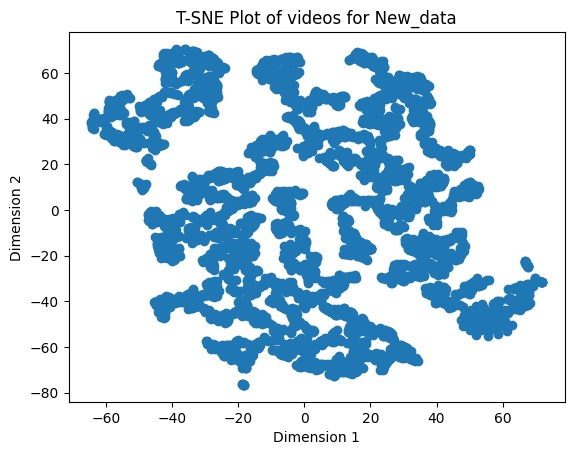

In [195]:
%matplotlib inline
plt.scatter(X_embedded[:,0],X_embedded[:,1])
plt.title("T-SNE Plot of videos for New_data")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

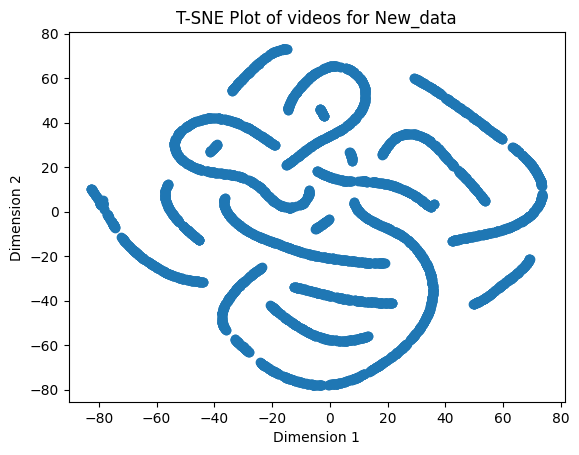

In [169]:
%matplotlib inline
plt.scatter(X_embedded[:,0],X_embedded[:,1])
plt.title("T-SNE Plot of videos for New_data")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()